### Non-Linear Models
- Kernal-Rdige Regression
  -  ‘linear’, ‘poly’, ‘rbf’
- SVR
  - 'linear', 'rbf'
- Ensemble Model
  - AdaBoost Regressor
  - Bagging Regressor
  - Gradient Boosting Regressor
  - Random Forest Regressor
- NN
  - MLP Regressor
- Nearest Neighbors
  - KNeighbors Regressor
  
http://scikit-learn.org/stable/modules/classes.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# models
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def load_data():
    df = pd.read_csv("../data/autos_removed_target_mv.csv")
    return df

# drop all missing vals
def handling_mv(df):
    df = df.replace("?", np.nan)
    df = df.dropna()
    return df

# preprocessing
def preprocessing(df):
    y = df['normalized-losses']
    X = df.ix[:, 1:]
    
    # divide real and cat vals
    cols_real = list(X.describe().columns)
    cols_cat = [col for col in X.columns if col not in cols_real]
    X_real = X[cols_real]
    X_cat = X[cols_cat]
    
    # scaling real vlas (minmax scale; 0~1)
    X_scaled = minmax_scale(X_real)
    dfX_scale = pd.DataFrame(X_scaled, columns=cols_real)

    # dummies cat vals
    X_dummies = pd.get_dummies(X_cat)
    
    # reindex & merge real and cat DF
    dfX_scale.reset_index(drop=True, inplace=True)
    X_dummies.reset_index(drop=True, inplace=True)
    X_pre = pd.concat([dfX_scale, X_dummies], axis=1)
    
    return X_pre, y

df = load_data()
df = handling_mv(df)
X_pre, y = preprocessing(df)

In [3]:
# grid search cv
def modeling(algo, param_grid, cv=None, scoring="neg_mean_squared_error"):    
    model = GridSearchCV(algo,
                        param_grid,
                        cv=cv,
                        scoring=scoring)
    return model.fit(X_pre, y)

# parameter search result
def param_search(model):
    rmse = (-model.cv_results_['mean_test_score'])**(1/2)
    print("best param: ", model.best_params_, "\nmin rmse: ", np.min(rmse))
    
# parameter search graph 2D, 3D
def param_graph(model, *args):
    rmse = (-model.cv_results_['mean_test_score'])**(1/2)
    
    param_list = []
    
    for idx, arg in enumerate(*args):
        param = [x[arg] for x in model.cv_results_['params']]
        param_list.append(param)
        
    if len(param_list) == 1:
        x = param_list[0]
        y = rmse
        
        plt.style.use("seaborn-white")
        plt.scatter(x=x, y=y)
        print("best param: ", model.best_params_, "\nmin rmse: ", np.min(rmse))
    
    elif len(param_list) == 2:
        x = param_list[0]
        y = param_list[1]
        z = rmse
        xx, yy = np.meshgrid(x, y)

        fig = plt.figure()
        ax = Axes3D(fig)
        ax.plot_surface(xx, yy, z, cmap='rainbow')
        plt.show()
        print("best param: ", model.best_params_, "\nmin rmse: ", np.min(rmse))
        
    else:
        print("lenth of param_names list must be 1 or 2")

### KERNEL RIDGE

In [4]:
param_grid = {
    "alpha": np.logspace(-2, 1, 50),
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid']
}

kernel_ridge_model = modeling(KernelRidge(), param_grid, cv=10)

best param:  {'alpha': 0.29470517025518095, 'kernel': 'linear'} 
min rmse:  29.496329546858455


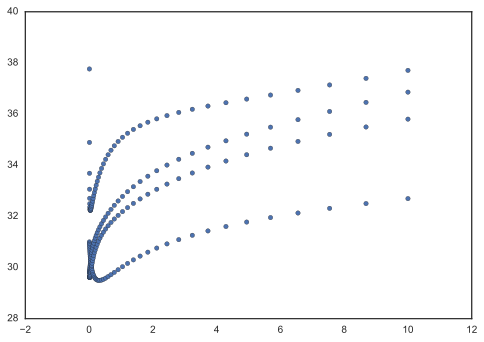

In [5]:
param_graph(kernel_ridge_model, ['alpha'])

### SVR

In [6]:
param_grid = {
    "kernel": ['rbf', 'linear'],
    "C": np.linspace(0.1, 3, 10),
    "epsilon": np.logspace(-2, 0, 20),
    "gamma": np.linspace(1, 10, 10)
}

svr_model = modeling(SVR(), param_grid, cv=5)

best param:  {'C': 3.0, 'gamma': 1.0, 'epsilon': 0.29763514416313175, 'kernel': 'linear'} 
min rmse:  34.421741348392324


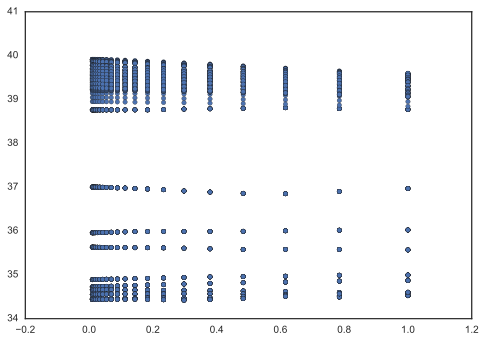

In [7]:
param_graph(svr_model, ['epsilon'])

best param:  {'C': 3.0, 'gamma': 1.0, 'epsilon': 0.29763514416313175, 'kernel': 'linear'} 
min rmse:  34.421741348392324


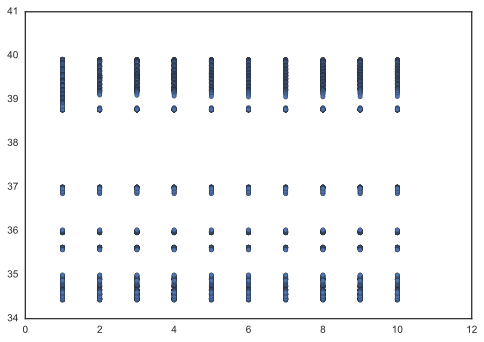

In [8]:
param_graph(svr_model, ['gamma'])

### AdaBoost

In [9]:
param_grid = {
    "learning_rate": np.linspace(0.01, 3, 20),
    "loss": ['linear', 'square', 'exponential']
}

ada_model = modeling(AdaBoostRegressor(), param_grid, cv=5)

best param:  {'loss': 'exponential', 'learning_rate': 2.055789473684211} 
min rmse:  33.73934536389013


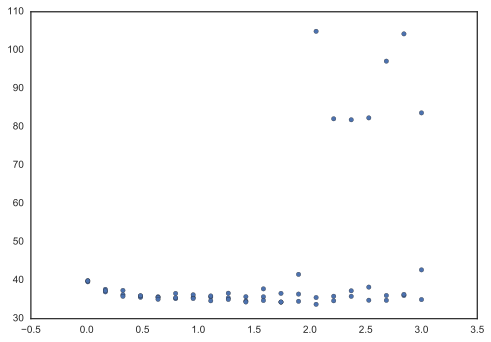

In [10]:
param_graph(ada_model, ['learning_rate'])

### GBM

In [11]:
param_grid = {
    "loss": ['ls', 'lad', 'huber', 'quantile'],
    "learning_rate": np.linspace(0.01, 3, 20),
    "n_estimators": np.arange(1, 10),
    "max_depth": np.arange(1, 5)
}

gbm = modeling(GradientBoostingRegressor(), param_grid, cv=5)

best param:  {'max_depth': 4, 'loss': 'lad', 'n_estimators': 3, 'learning_rate': 0.4821052631578948} 
min rmse:  33.367119412627545


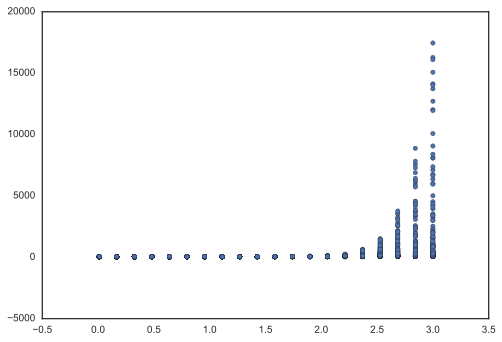

In [12]:
param_graph(gbm, ['learning_rate'])

best param:  {'max_depth': 4, 'loss': 'lad', 'n_estimators': 3, 'learning_rate': 0.4821052631578948} 
min rmse:  33.367119412627545


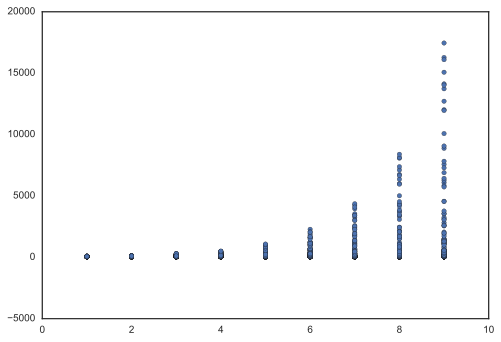

In [13]:
param_graph(gbm, ['n_estimators'])

best param:  {'max_depth': 4, 'loss': 'lad', 'n_estimators': 3, 'learning_rate': 0.4821052631578948} 
min rmse:  33.367119412627545


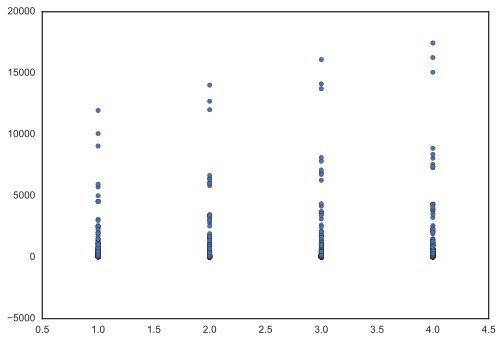

In [14]:
param_graph(gbm, ['max_depth'])

### Bagging

In [15]:
param_grid = {
    "n_estimators": np.arange(1, 10),
    "max_samples": np.arange(10, 20),
    "max_features": np.arange(10, 20),
}

bagging_model = modeling(BaggingRegressor(), param_grid, cv=5)

best param:  {'max_samples': 16, 'max_features': 14, 'n_estimators': 3} 
min rmse:  31.35527132448841


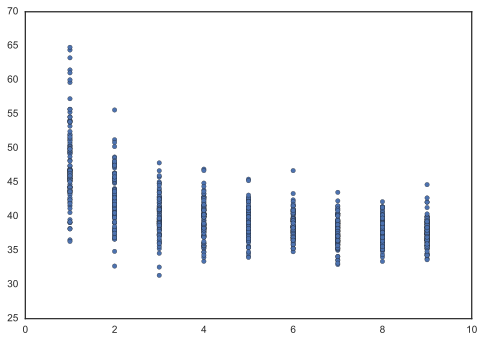

In [16]:
param_graph(bagging_model, ['n_estimators'])

best param:  {'max_samples': 16, 'max_features': 14, 'n_estimators': 3} 
min rmse:  31.35527132448841


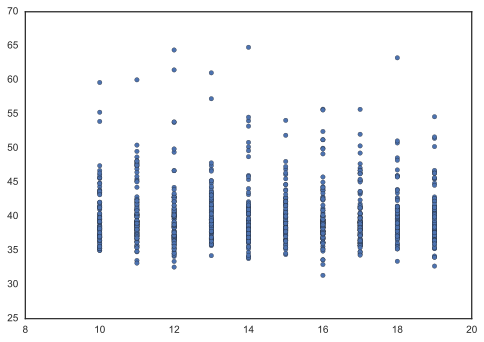

In [17]:
param_graph(bagging_model, ['max_samples'])

best param:  {'max_samples': 16, 'max_features': 14, 'n_estimators': 3} 
min rmse:  31.35527132448841


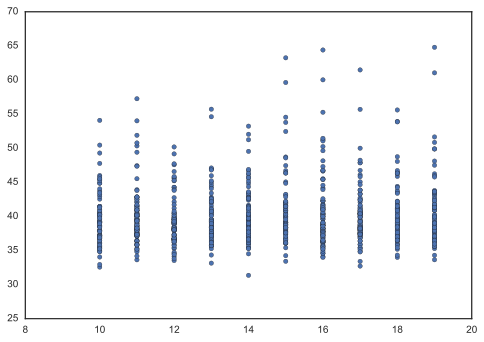

In [18]:
param_graph(bagging_model, ['max_features'])

### RF

In [19]:
param_grid = {
    "n_estimators": np.arange(1, 10),
    "max_depth": np.arange(1, 5),
}

rf_model = modeling(RandomForestRegressor(), param_grid, cv=5)

best param:  {'max_depth': 3, 'n_estimators': 2} 
min rmse:  36.59797077447872


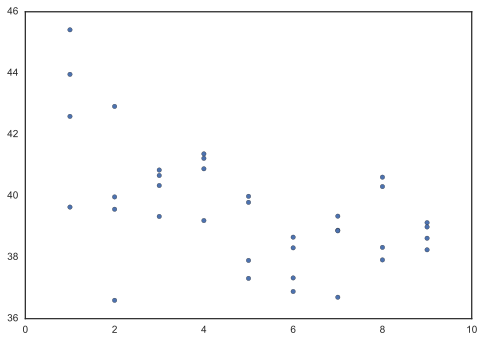

In [20]:
param_graph(rf_model, ['n_estimators'])

best param:  {'max_depth': 3, 'n_estimators': 2} 
min rmse:  36.59797077447872


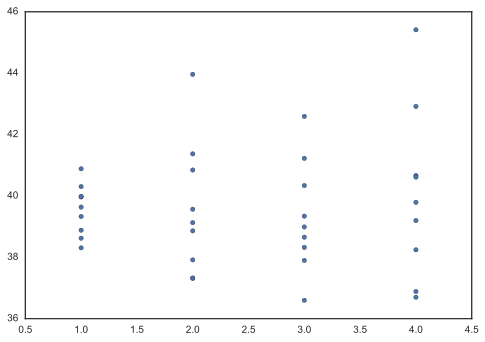

In [21]:
param_graph(rf_model, ['max_depth'])

### NN

In [22]:
param_grid = {
    "hidden_layer_sizes": [(100, 10)],
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "learning_rate_init": np.linspace(0.005, 2, 20)
}

nn_model = modeling(MLPRegressor(), param_grid, cv=5)

/Users/jkpark/.pyenv/versions/3.5.1/envs/dss/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jkpark/.pyenv/versions/3.5.1/envs/dss/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jkpark/.pyenv/versions/3.5.1/envs/dss/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


best param:  {'hidden_layer_sizes': (100, 10), 'learning_rate_init': 0.005, 'learning_rate': 'invscaling'} 
min rmse:  40.7344754639051


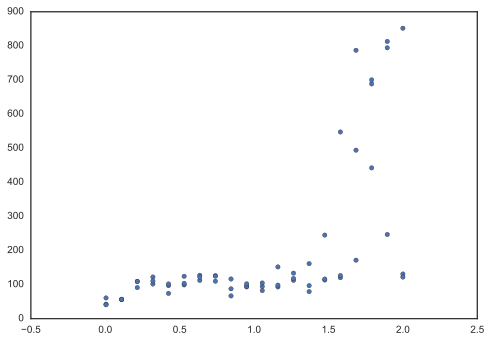

In [23]:
param_graph(nn_model, ['learning_rate_init'])

### KN

In [26]:
param_grid = {
    "n_neighbors": np.arange(1, 30),
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

kn_model = modeling(KNeighborsRegressor(), param_grid, cv=5)

best param:  {'weights': 'distance', 'algorithm': 'brute', 'n_neighbors': 23} 
min rmse:  35.41668773068977


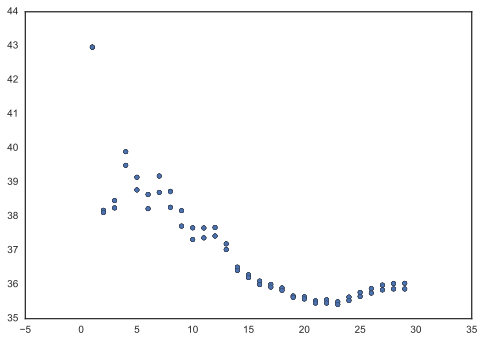

In [27]:
param_graph(kn_model, ['n_neighbors'])